# 0. Install and Import Dependencies

In [4]:
!pip install easyocr
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=0633c938d6aefb08381bd2af129ef24c6bae355bf161cb60f9e721306e3244af
  Stored in directory: /Users/vishnumano/Library/Caches/pip/wheels/31/d0/2c/87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils


In [6]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

# 1. Read in Image, Grayscale, and Blur

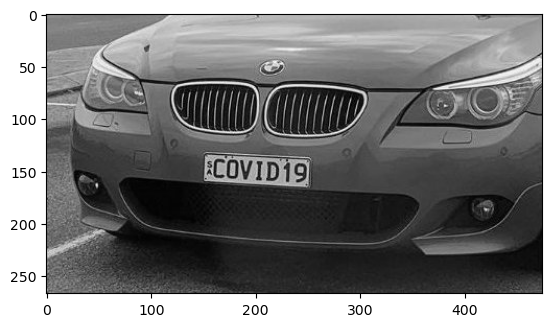

In [12]:
img = cv2.imread('image2.jpg') # read in image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # recolor image2 from BlueGreenRed to Gray
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)) # convert grayscaled image2 from BGR to RGB

# 2. Apply Filter and Find Edges for Localization

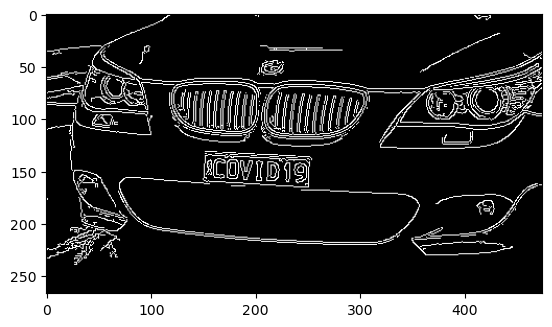

In [18]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # Noise Reduction through Bilateral Filter
edged = cv2.Canny(bfilter, 30, 200) # Edge detection using Canny algorithm
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB)) # convert edged from BGR to RGB for visualization

# 3. Find Contours and Apply Mask

In [23]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Finding Contours - params(input image, return type(tree to find different levels of contours), type of result (approximated/simplified version of countour))
contours = imutils.grab_contours(keypoints) # Grabs the contours and simplifies them to tuple
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # sorts top 10 contours by descending contour area

In [24]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [25]:
location

array([[[152, 136]],

       [[248, 139]],

       [[251, 164]],

       [[153, 160]]], dtype=int32)

# 4. Use Easy OCR to Read Text

# 5. Render Result